In [46]:
from fastai.vision.all import *
import torchaudio
from sklearn.model_selection import StratifiedKFold


In [2]:
df_train = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/train.csv')
df_test = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/test.csv')
submission = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/sample_submission.csv')

In [3]:
train_path = Path('/home/ubuntu/.kaggle/resampled/resampled_train/')
test_path = Path('/home/ubuntu/.kaggle/resampled/resampled_test/')

In [4]:
train_files = get_files(train_path, extensions='.wav')


In [5]:
train_files

(#19909) [Path('/home/ubuntu/.kaggle/resampled/resampled_train/018663_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/008647_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/018904_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/001706_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/003820_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/013023_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/009569_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/017429_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/008264_16k.wav'),Path('/home/ubuntu/.kaggle/resampled/resampled_train/000141_16k.wav')...]

In [6]:
def get_y(filename):
    resample_name = filename.name.split('_')[0] + '.ogg'
    return df_train[df_train['filename']==resample_name]['genre'].values[0]

In [74]:
# Excluded unusual music thanks to this thread: https://www.kaggle.com/c/kaggle-pog-series-s01e02/discussion/312842
def get_items(path): 
    excluded_files = ["010449_16k.wav" , "005589_16k.wav" , "004921_16k.wav", "019511_16k.wav" , "013375_16k.wav" , "024247_16k.wav", "024156_16k.wav"]
    items = get_files(path, extensions='.wav')
    items = [item for item in items if item.name not in excluded_files]
    
    ## For fast iteration
#     items = [item for item in items if get_y(item) in ['Punk', 'Rock']]
    
#     items.shuffle()
    return L(items)

In [8]:
N_FFT = 2048
HOP_LEN = 512

In [9]:
filename = train_files[0]


In [10]:
filename.name.split('_')[0] + '.ogg'


'018663.ogg'

In [80]:
def create_spectrogram(filename):
    audio, sr = torchaudio.load(filename)
    specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, 
                                                    n_fft=N_FFT, 
                                                    win_length=N_FFT, 
                                                    hop_length=HOP_LEN*2,
                                                    center=True,
                                                    pad_mode="reflect",
                                                    power=2.0,
                                                    norm='slaney',
                                                    onesided=True,
                                                    n_mels=128,
                                                    mel_scale="htk"
                                                   )(audio)[0]
    specgram = torchaudio.transforms.AmplitudeToDB()(specgram)
    specgram = specgram - specgram.min()
    specgram = specgram/specgram.max()*255
    
#     specgram = specgram.unsqueeze(0)
    return specgram

In [14]:
items = get_items(train_path)
labels = [get_y(item) for item in items]

Counter({'Chiptune / Glitch': 1180,
         'International': 814,
         'Punk': 2581,
         'Hip-Hop': 1755,
         'Ambient Electronic': 796,
         'Electronic': 3071,
         'Folk': 1213,
         'Country': 142,
         'Rock': 3095,
         'Experimental': 1799,
         'Pop': 945,
         'Instrumental': 1043,
         'Classical': 495,
         'Old-Time / Historic': 408,
         'Jazz': 306,
         'Spoken': 94,
         'Soul-RnB': 94,
         'Blues': 58,
         'Easy Listening': 13})

In [96]:
items = items[:5000]

In [98]:
labels = labels[:5000]

In [ ]:
def alter_learner(learn, channels=1):
    learn.model[0][0][0].in_channels=channels
    learn.model[0][0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0][0].weight[:,1,:,:].unsqueeze(1))

In [56]:
x, y = dls.one_batch()

In [57]:
x.shape

torch.Size([128, 128, 469])

In [66]:
dsrc[0][0].unsqueeze(0)

torch.Size([1, 128, 469])

In [100]:
def fake_get_items(_): return items

In [90]:
def genreid_from_genre(genre):
    return int(genre2id[genre2id['genre'] == genre]['genre_id'].values[0])

In [99]:
bs = 128
kf = StratifiedKFold(n_splits=5, shuffle=True)
preds_ls = []

for _, val_idx in kf.split(np.array(items), labels):
    splits = IndexSplitter(val_idx)
    split = splits(items)
    split_list = [split[0], split[1]]
    
    db = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=fake_get_items,
        get_x=create_spectrogram,
        get_y=get_y,
        splitter=splitter,
        item_tfms=[Resize(128)],
        batch_tfms=aug_transforms(max_rotate=0, max_warp=0,size=128))
    
    dls = db.dataloaders(train_path, bs=64)
    mixup = MixUp(0.2)
    model = partial(xse_resnet18, pool=MaxPool)
    
    learn = cnn_learner(dls, 
                        model, 
                        metrics=[accuracy, F1Score(average='micro')], 
                        pretrained=False, 
                        loss_func=LabelSmoothingCrossEntropy(), 
                        opt_func=ranger, 
                       )
    
    learn.to_fp16()
        
    nchannels = dls.one_batch()[0].shape[1]
    alter_learner(learn, nchannels)

    learn.fit_flat_cos(1, 0.003, cbs=[mixup, CSVLogger()], wd=1e-2)
    
    test_items = get_items(test_path)
    test_dl = dls.test_dl(test_items)
    preds = learn.get_preds(dl=test_dl)
    preds_ls.append(np.array(preds[0]))


/home/ubuntu/miniconda3/envs/pytorchvideo/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [5000, 19902]

In [95]:
preds_ls[0][0]

TensorBase([[0.0767, 0.0293, 0.0055,  ..., 0.0655, 0.0129, 0.0363],
        [0.0452, 0.0103, 0.0499,  ..., 0.2079, 0.0147, 0.0049],
        [0.0041, 0.0110, 0.0225,  ..., 0.1173, 0.0257, 0.0571],
        ...,
        [0.0117, 0.0043, 0.0239,  ..., 0.3955, 0.0147, 0.0046],
        [0.1230, 0.0158, 0.0308,  ..., 0.1200, 0.0102, 0.0022],
        [0.0093, 0.0108, 0.0146,  ..., 0.0344, 0.0013, 0.0024]])

In [ ]:
preds_idx = preds[0].argmax(axis=1)
genre2id = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/genres.csv')
songid_preds = {int(file_path.name.split('_')[0]):genreid_from_genre(learn.dls.vocab[_id]) for file_path, _id in zip(test_items,preds_idx)}
submission['genre_id'] = submission['song_id'].map(songid_preds)
submission['genre_id'].fillna(0, inplace=True)
submission.genre_id = submission.genre_id.astype(int)
submission.to_csv(f"submission_{int(time.time())}.csv", index=False)

In [17]:
splitter = TrainTestSplitter(test_size=0.2, random_state=42, stratify=labels)

In [87]:
dls = db.dataloaders(train_path, bs=64)

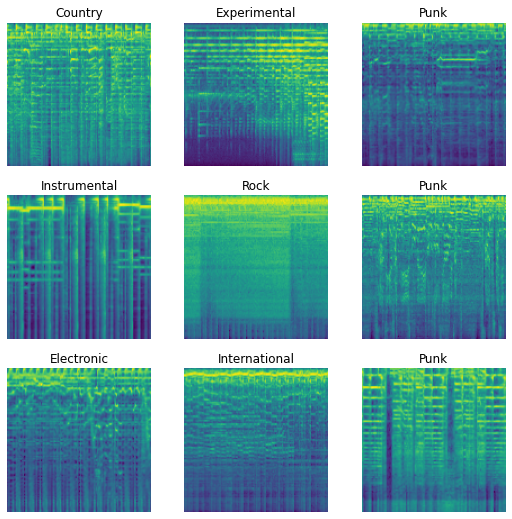

In [88]:
dls.show_batch()


In [ ]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=fake_get_items,
    get_x=create_spectrogram,
    get_y=get_y,
    splitter=splitter,
    item_tfms=[Resize(128)],
    batch_tfms=aug_transforms(max_rotate=0, max_warp=0,size=128))

dls = db.dataloaders(train_path, bs=64)

In [22]:
mixup = MixUp(0.2)

In [36]:
model = partial(xse_resnet18, pool=MaxPool)

In [37]:
learn = cnn_learner(dls, 
                    model, 
                    metrics=[accuracy, F1Score(average='micro')], 
                    pretrained=False, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=ranger, 
                   )

In [39]:
learn.to_fp16()

In [40]:
## This is to make model works with 1-channel input
def alter_learner(learn, channels=1):
    learn.model[0][0][0].in_channels=channels
    learn.model[0][0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0][0].weight[:,1,:,:].unsqueeze(1))

In [41]:
nchannels = dls.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(valley=0.007585775572806597)

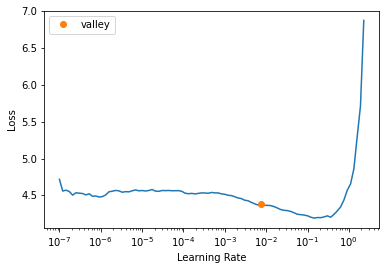

In [42]:
learn.lr_find()

In [43]:
learn.fit_flat_cos(1, 0.003, cbs=[mixup, CSVLogger()], wd=1e-2)


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,2.854975,2.146929,0.386335,0.386335,02:13


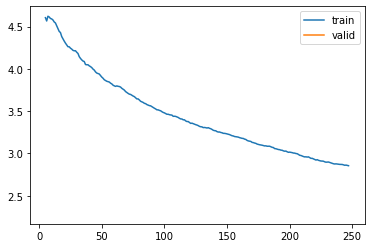

In [30]:
learn.recorder.plot_loss()


In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)

True

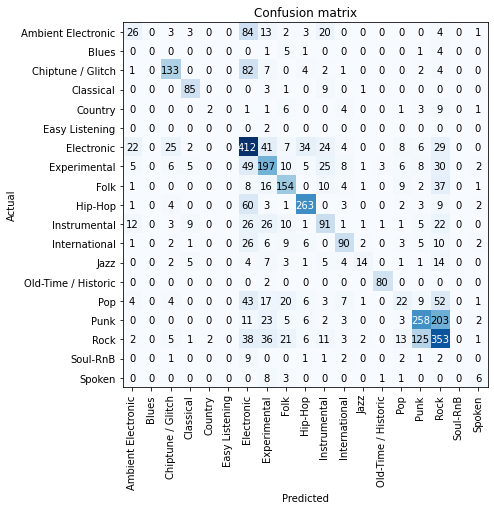

In [29]:
interp.plot_confusion_matrix(figsize=(7,7))


In [31]:
filename.name.split('_')[0]


'018663'

In [34]:
test_items = get_items(test_path)
test_dl = dls.test_dl(test_items)
preds = learn.get_preds(dl=test_dl)
preds_idx = preds[0].argmax(axis=1)
genre2id = pd.read_csv('/home/ubuntu/.kaggle/kaggle-pog-series-s01e02/genres.csv')
songid_preds = {int(file_path.name.split('_')[0]):genreid_from_genre(learn.dls.vocab[_id]) for file_path, _id in zip(test_items,preds_idx)}
submission['genre_id'] = submission['song_id'].map(songid_preds)
submission['genre_id'].fillna(0, inplace=True)
submission.genre_id = submission.genre_id.astype(int)
submission.to_csv(f"submission_{int(time.time())}.csv", index=False)